Map conformational landscapes of intrinsically disordered proteins with polymer physics quantities.
    Shadman, H.; Ziebarth, J. D.; Gallops, C. E.; Luo, R.; Li, Z.; Chen, H.-F.; Wang, Y. Biophysical Journal 2024
    
   * How can we characterize the conformational diversity of disordered proteins using a combination of the instantaneous shape ratio (Rs) and the radius of gyration (Rg) as a simple map of the conformational landscape?
    How can we quantify the conformational diversity of disordered proteins using the fraction of GW conformations (fC)?
        1. Import pdbs and trajectories
        2. Visualize protein with trajectory
        3. Create input csv files, where the first column is (radius of gyration)^2 and the second column is the (end to end distance)^2 for each frame of the trajectory
        4. Utilize Shadman code to generate Two-Dimensional Scatter Plots from csv files
            https://github.com/hshadman/2d_conformational_landscape_map/tree/main
        5.  Analyze the protein and polymer with the second jupyter file called ab40. Can we observe similarities in the conformational maps between disordered proteins and a polymer at various states?

In [7]:
# 2d_conformational_landscape_map from Shadman, H.

#these packages are needed to run the code 

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import spatial
from itertools import chain
from more_itertools import sliced
from matplotlib.ticker import MaxNLocator
import random as rd
import mdtraj as md


In [17]:
# import pdb and trajectories

pdb='/Users/NLoui/Desktop/CHEM101.6/FinalProject/data/Ab40.pdb'
trajectory='/Users/NLoui/Desktop/CHEM101.6/FinalProject/data/Ab40-a99SBdisp-Traj.dcd'
outdir='/Users/NLoui/Desktop/CHEM101.6/FinalProject/outdir'
if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trajectory:",trajectory)

outdir: /Users/NLoui/Desktop/CHEM101.6/FinalProject/outdir
pdb: /Users/NLoui/Desktop/CHEM101.6/FinalProject/data/Ab40.pdb
trajectory: /Users/NLoui/Desktop/CHEM101.6/FinalProject/data/Ab40-a99SBdisp-Traj.dcd


In [18]:
stride_sel=1
trj = md.load(trajectory, top=pdb,stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames
trj_length=125
time=np.linspace(0,125,n_frames)

In [10]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])


#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 598

Number of residues: 40

Number of frames: 29977

Starting frame: 0

Last frame: 29977

sequence:  [ASP1, ALA2, GLU3, PHE4, ARG5, HIS6, ASP7, SER8, GLY9, TYR10, GLU11, VAL12, HIS13, HIS14, GLN15, LYS16, LEU17, VAL18, PHE19, PHE20, ALA21, GLU22, ASP23, VAL24, GLY25, SER26, ASN27, LYS28, GLY29, ALA30, ILE31, ILE32, GLY33, LEU34, MET35, VAL36, GLY37, GLY38, VAL39, VAL40, ASP1, HIS6, HIS13, HIS14]

residue names:  ['ASP', 'ALA', 'GLU', 'PHE', 'ARG', 'HIS', 'ASP', 'SER', 'GLY', 'TYR', 'GLU', 'VAL', 'HIS', 'HIS', 'GLN', 'LYS', 'LEU', 'VAL', 'PHE', 'PHE', 'ALA', 'GLU', 'ASP', 'VAL', 'GLY', 'SER', 'ASN', 'LYS', 'GLY', 'ALA', 'ILE', 'ILE', 'GLY', 'LEU', 'MET', 'VAL', 'GLY', 'GLY', 'VAL', 'VAL', 'ASP', 'HIS', 'HIS', 'HIS']

residue number:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 1, 6, 13, 14]

residue index:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1

In [11]:
# needed input is a csv file (for a given protein/polymer simulation) with 2 columns. 
    
    # The first column contains Rg^2 values, square of gyration radius
        #Lets calculate the radius of gyration    
    # The second column contains Ree2 values, square of the end-to-end distance

# In this file, each row represents a protein/polymer conformation snapshot from the simulation.

In [12]:
# Calculate radius of gyration

rg=md.compute_rg(trj, masses=None)
rg


array([1.26818913, 1.31485405, 1.27095181, ..., 2.00941507, 1.94058582,
       1.74628042])

In [19]:
trj.center_coordinates()

# Initialize an array to store the radius of gyration for each frame
rg_values = np.zeros(trj.n_frames)

# Calculate the radius of gyration for each frame
for i in range(trj.n_frames):
    rg_values[i] = md.compute_rg(trj[i])

# Print the radius of gyration for each frame
# for frame, rg in enumerate(rg_values):
#     print(f"Frame {frame}: Radius of gyration = {rg:.3f} nm")

In [21]:
outdir_file = '/Users/NLoui/Desktop/CHEM101.6/FinalProject/rg_squared.csv'


# Calculate the radius of gyration for each frame
rg_squared = np.zeros(trj.n_frames)

for i in range(trj.n_frames):
    rg = md.compute_rg(trj[i])
    rg_squared[i] = rg**2

# Create a DataFrame and save to CSV
df = pd.DataFrame({'Frame': np.arange(trj.n_frames), 'Rg_squared': rg_squared})
df.to_csv(outdir_file, index=False)

print(f"Squared radius of gyration values saved to {outdir_file}")

Squared radius of gyration values saved to /Users/NLoui/Desktop/CHEM101.6/FinalProject/rg_squared.csv


Squared End-to-End Distances (R_ee^2) for each frame: [ 6.709018  4.863108  5.104583 ... 10.773951  3.801325  8.065619]


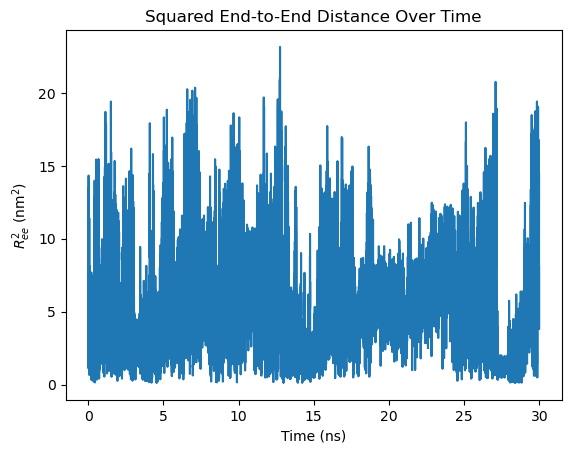

In [13]:
# Calculate Ree^2 values 

# Define atom indices for the ends (example indices)
atom_start = 0
atom_end = -1

# Calculate the squared end-to-end distance
distances_squared = np.sum((trj.xyz[:, atom_start, :] - trj.xyz[:, atom_end, :]) ** 2, axis=1)

# Print the squared end-to-end distance for each frame
print(f"Squared End-to-End Distances (R_ee^2) for each frame: {distances_squared}")

# Time array in nanoseconds (assuming 1 frame = 1 ps, adjust as necessary)
time = trj.time / 1000  # Convert to nanoseconds if trajectory.time is in picoseconds

# Plot the squared end-to-end distance over time
plt.figure()
plt.plot(time, distances_squared)
plt.xlabel('Time (ns)')
plt.ylabel('$R_{ee}^2$ (nm$^2$)')
plt.title('Squared End-to-End Distance Over Time')
plt.show()


In [14]:
trj.center_coordinates()

# Extract the atom indices of the first and last residues
first_residue = trj.topology.residue(0)
last_residue = trj.topology.residue(trj.topology.n_residues - 1)

# Get the atom indices of the first and last atom of the first and last residue, respectively
first_atom_index = first_residue.atom(0).index
last_atom_index = last_residue.atom(last_residue.n_atoms - 1).index

# Calculate the end-to-end distance for each frame
end_to_end_distances = np.zeros(trj.n_frames)

for i in range(trj.n_frames):
    coord_first_atom = trj.xyz[i, first_atom_index, :]
    coord_last_atom = trj.xyz[i, last_atom_index, :]
    distance = np.linalg.norm(coord_last_atom - coord_first_atom)
    end_to_end_distances[i] = distance

# Print the end-to-end distances
# for frame, distance in enumerate(end_to_end_distances):
#     print(f"Frame {frame}: End-to-end distance = {distance:.3f} nm")

Frame 0: End-to-end distance = 2.590 nm
Frame 1: End-to-end distance = 2.205 nm
Frame 2: End-to-end distance = 2.259 nm
Frame 3: End-to-end distance = 2.070 nm
Frame 4: End-to-end distance = 2.381 nm
Frame 5: End-to-end distance = 2.497 nm
Frame 6: End-to-end distance = 2.464 nm
Frame 7: End-to-end distance = 2.637 nm
Frame 8: End-to-end distance = 2.139 nm
Frame 9: End-to-end distance = 2.203 nm
Frame 10: End-to-end distance = 1.881 nm
Frame 11: End-to-end distance = 2.062 nm
Frame 12: End-to-end distance = 3.316 nm
Frame 13: End-to-end distance = 3.203 nm
Frame 14: End-to-end distance = 2.143 nm
Frame 15: End-to-end distance = 1.103 nm
Frame 16: End-to-end distance = 1.420 nm
Frame 17: End-to-end distance = 2.840 nm
Frame 18: End-to-end distance = 2.085 nm
Frame 19: End-to-end distance = 2.053 nm
Frame 20: End-to-end distance = 3.669 nm
Frame 21: End-to-end distance = 3.369 nm
Frame 22: End-to-end distance = 2.397 nm
Frame 23: End-to-end distance = 2.522 nm
Frame 24: End-to-end dista

In [22]:
outdir_file = '/Users/NLoui/Desktop/CHEM101.6/FinalProject/ree_squared.csv'

trj.center_coordinates()

# Extract the atom indices of the first and last residues
first_residue = trj.topology.residue(0)
last_residue = trj.topology.residue(trj.topology.n_residues - 1)

# Get the atom indices of the first and last atom of the first and last residue, respectively
first_atom_index = first_residue.atom(0).index
last_atom_index = last_residue.atom(last_residue.n_atoms - 1).index

# Calculate the end-to-end distance for each frame
ree_squared = np.zeros(trj.n_frames)

for i in range(trj.n_frames):
    coord_first_atom = trj.xyz[i, first_atom_index, :]
    coord_last_atom = trj.xyz[i, last_atom_index, :]
    distance = np.linalg.norm(coord_last_atom - coord_first_atom)
    ree_squared[i] = distance**2

# Create a DataFrame and save to CSV
df = pd.DataFrame({'Frame': np.arange(trj.n_frames), 'Ree_squared': ree_squared})
df.to_csv(outdir_file, index=False)

print(f"Squared radius of gyration values saved to {outdir_file}")

Squared radius of gyration values saved to /Users/NLoui/Desktop/CHEM101.6/FinalProject/ree_squared.csv


In [29]:
outdir_file = '/Users/NLoui/Desktop/CHEM101.6/FinalProject/2D_plot_input_1.csv'

# Create a DataFrame of rg_squared and ree_squared and save to CSV
df = pd.DataFrame({'Rg_squared': rg_squared, 'Ree_squared': ree_squared})
df.to_csv(outdir_file, index=False)

print(f"values of rg and ree squared for 2d conform plot {outdir_file}")

values of rg and ree squared for 2d conform plot /Users/NLoui/Desktop/CHEM101.6/FinalProject/2D_plot_input_1.csv


In [20]:
# 2d_conformational_landscape_map from Shadman, H.
# Generates Two-Dimensional Scatter Plots


class PyConforMap():
    
    """
     A class used to represent a 2D map of the conformational landscape of a protein or polymer chain. The 2D map
     is in the form of a scatter plot of relative radius of gyration and instantaneous shape ratio. These quantities
     are plotted for a given protein/polymer and for a reference GW polymer chain model. Different metrics 
     of the scatter can be studied using this class. An example is the fC score, ranging from 0 to 1, that 
     quantifies conformational diversity of the provided protein or polymer chain. 

    ...

    Attributes
    ----------
    protein_rg2 : array
        the square of the radius of gyration values of protein/polymer
        
    protein_ree2 : array
        the square of the end-to-end distance values of protein/polymer
        
    protein_rg_mean : float
        The mean of the protein/polymer radius of gyration, computed from all data combined.
        
    GW_df : pandas dataframe
        A dataframe of the GW reference simulation, which by default is the provided GW_chainlen100.csv file. 
        The columns, in order, are GW chain length, square of radius of gyration, square of end-to-end distance,
        relative radius of gyration, and instantaneous shape ratio. 
        Each row represents a conformation snapshot from the GW simulation.
        
    poly_var : pandas dataframe of shape (n,2)
        A dataframe of the protein/polymer simulation. 
        The first column is Rg/Rg_mean and the second column is instantaneous shape ratio. 
        Each row represents a conformation snapshot from the protein/polymer simulation.        
        
    Methods
    -------
    plot_protein_against_GW 
        - generates the 2D scatter plot
        
    check_boundary
        - computes % of protein/polymer points within the pre-assigned radius of GW points
        
    change_xlim_ylim
        - update x-axis and y-axis limits of 2D scatter plot
        
    vary_protein
        - plot fC against protein/polymer snapshots
        
    vary_GW_ref
        - plot fC against GW snapshots        
        
    regenerate_GW_chain
        - simulates new GW reference chain        

    save_GW_chain_to_csv
        - save current GW chain data to a csv file
        
    retrieve_default_GW_chain
        - revert to default reference simulation        
        
    """



In [22]:
    def __init__(self, csv_file,radius_= 0.1,max_x_val=3,max_y_val=30,min_x_val=0,min_y_val=0):
        
        #load csv file, where first column is supposed to be Rg2 values and second column is Ree2 values
        #initialize the rg2 and ree2 variables
        df_conf = pd.read_csv(csv_file)
        self.protein_rg2 = df_conf.iloc[:,0].values
        self.protein_ree2 = df_conf.iloc[:,1].values
        
        #calculate and store an rg_mean value from complete dataset
        self.protein_rg = self.protein_rg2**0.5
        self.protein_rg_mean = np.mean(self.protein_rg)
        
        #initialize the reference GW chain data (by default a GW chain with 100 monomers is used)
        #any file containing GW reference chain data must be a pandas df containing atleast 'Rg2' and 'Rend2' columns
        #the 'Rg2' is radius-of-gyration^2 and 'Rend2' is end-to-end-distance^2
        #the instantaneous shape ratio is calculated here
        #the file containing GW reference chain data should also have Rg/Rg_mean data
        #the self.GW_df MUST be single chain length
        self.GW_df = pd.read_csv('GW_chainlen100.csv')
        self.GW_df['ratio'] = self.GW_df['Rend2'].values/self.GW_df['Rg2'].values
        
        #the default radius is 0.1
        self.radius_ = radius_
        
        #the default xlim max is 3 and xlim min is 0
        #the default ylim max is 30 and ylim min is 0        
        self.max_x_val=max_x_val
        self.max_y_val=max_y_val  
        self.min_x_val=min_x_val
        self.min_y_val=min_y_val  
        
        #by default, using all protein snapshots provided in the datafile (can be modified here if needed)
        self.upto_protein_snapshots = len(self.protein_ree2)
        
        #by default using all GW snapshots provided in the datafile
        self.GW_every_ith_snap = self.GW_df.shape[0]
        
        #initialize the protein dataframe and both GW and protein coordinates
        self.organize_data(self.protein_rg2,self.protein_ree2,self.upto_protein_snapshots,self.GW_every_ith_snap)
        
        #for the loaded data, print out what % is close to GW points
        self.check_boundary()
        
    

In [23]:
def plot_protein_against_GW(self,protein_label,provided_color='magenta'):

        #x-axis label and y-axis label
        x_variable=r'$R_g\left/R_g^{mean}\right.$' 
        y_variable="Instantaneous Shape Ratio"        
 

        plt.rcParams["font.weight"] = "regular"
        plt.rcParams["axes.labelweight"] = "regular"
        
        #several scatter plot markers are set here
        scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]

        #save x_total and y_total and x_polmodel_GW and y_polmodel_GW as simple lists
        x_total = self.poly_var['Rg/Rg_mean'].values.tolist()
        y_total = self.poly_var['ratio'].values.tolist()
        x_polmodel_GW = self.GW_df['Rg/Rg_mean'].values.tolist()
        y_polmodel_GW = self.GW_df['ratio'].values.tolist()

        #calculate fC value using fC method provided in class
        self.fC_value = self.fC_using_cdist(self.upto_protein_snapshots,
                                           self.GW_every_ith_snap,protein_name = 'protein')        

        #the rest of this function is plotting

        #Earlier in the class the default max_x_val and max_y_val were initialized (these are axis limits)
        #There is a separate method in the class if these default xlim and ylim values need to be changed
        #below it checks whether datapoints exceed the axis limits, and resets limits if they do
        #the default minimum axis limits for both x- and y-axis are 0
        if self.GW_df['Rg/Rg_mean'].max()>self.max_x_val:
            self.max_x_val = self.GW_df['Rg/Rg_mean'].max()
            print('x-axis maximum limit updated from default value')
        if self.GW_df['Rg/Rg_mean'].min()<self.min_x_val:
            self.min_x_val = self.GW_df['Rg/Rg_mean'].min()
            print('x-axis minimum limit updated from default value')            
        if max(x_total)>self.max_x_val:
            self.max_x_val = max(x_total)
            print('x-axis maximum limit updated from default value')            
        if min(x_total)<self.min_x_val:
            self.min_x_val = min(x_total)
            print('x-axis minimum limit updated from default value')            
        if self.GW_df['ratio'].max()>self.max_y_val:
            self.max_y_val = self.GW_df['ratio'].max()
            print('y-axis maximum limit updated from default value')                        
        if self.GW_df['ratio'].min()<self.min_y_val:   
            self.min_y_val = self.GW_df['ratio'].min()            
            print('y-axis minimum limit updated from default value')                        
        if max(y_total)>self.max_y_val:
            self.max_y_val = max(y_total)
            print('y-axis maximum limit updated from default value')                        
        if min(y_total)<self.min_y_val:
            self.min_y_val = min(y_total)
            print('y-axis minimum limit updated from default value')                        

        xlims = [self.min_x_val,self.max_x_val]
        ylims = [self.min_y_val,self.max_y_val]

            
        # Set up x and y labels
        xlabel = x_variable
        ylabel = y_variable

        # Define the locations for the axes (can modify as user wants), dimensions of each plot
        left, width = 0.12, 0.55
        bottom, height = 0.12, 0.55
        bottom_h = left_h = left+width
        rect_temperature = [left, bottom, width, height] # dimensions of temp plot
        rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
        rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

        # Set up the size of the figure (can modify as user wants)
        fig = plt.figure(1, figsize=(9.5,9))

        # Make the three plots
        # axTemperature is the scatter plot
        # axHistx and axHisty are the histograms on the top and side respectively
        axTemperature = plt.axes(rect_temperature) 
        axHistx = plt.axes(rect_histx) # x-axis histogram
        axHisty = plt.axes(rect_histy) # y-axis histogram

        #the xlims variable was previously described (contains axis limits for both axes)
        xmin = min(xlims)
        xmax = max(xlims)
        ymin = min(ylims)
        ymax = max(ylims)

        #Define the number of bins
        nxbins = 100
        nybins = 50
        nbins = nxbins+nybins
        
        #plot the reference GW scatter plot (Rg/Rg_mean against instantaneous shape ratio)
        axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                          marker=scatter_markers[3],s=40,alpha=0.6,color='black',
                           label='GW')

        #plot the protein scatter plot (Rg/Rg_mean against instantaneous shape ratio)
        axTemperature.scatter(x_total,
                   y_total,
                   marker=scatter_markers[0],s=40,alpha=0.6,color=provided_color,
                                          label=protein_label)                
        
        self.plot_style(axTemperature,xlabel,
                        ylabel,fontsize = 19, labelsize = 22, rotation = 0)

        #Set axis limits for scatter plot
        axTemperature.set_xlim(xlims)
        axTemperature.set_ylim(ylims)

        #Set up the histogram bins
        xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
        ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)

        #plot the histograms on the top and side
        axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',
                    alpha=0.5,density=True)
        axHistx.hist(x_total, bins=xbins, color = provided_color,
                    alpha=0.5,density=True)

        axHisty.hist(y_polmodel_GW, bins=ybins, color = 'black',orientation='horizontal',
                    alpha=0.5,density=True)

        axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',
                    alpha=0.5,density=True)

        #it does not matter what i set as xlabel for axHistx and ylabel for axHisty b/c i will remove these labels
        self.plot_style(axHistx,xlabel,
                        'Prob. Density',fontsize = 19, labelsize = 22, rotation = 0)
        self.plot_style(axHisty,'Prob. Density',
                        ylabel,fontsize = 19, labelsize = 22, rotation = 0)

        #add text on the scatter plot window, showing fC score 
        axTemperature.text(0.7,0.65,
                           '$f_C$ = '+format(self.fC_value,'0.3f'),
                          transform=axTemperature.transAxes,fontsize=18)
        
        #add legend for scatter plot
        axTemp_legend=axTemperature.legend(fontsize=15,loc='upper right')
        
        #cosmetic modifications
        frame = axTemp_legend.get_frame()
        frame.set_linewidth(1.6)
        frame.set_edgecolor('black')

        #Set up the histogram axis limits
        axHistx.set_xlim( xmin, xmax )
        axHisty.set_ylim( ymin, ymax )

        #cosmetic modifications
        axHisty.xaxis.set_major_locator(MaxNLocator(4))
        axHistx.yaxis.set_major_locator(MaxNLocator(3))
                    
        #for the x-axis and y-axis histograms, remove any marks or ticks on the x and y axis respectively
        axHistx.axes.get_xaxis().set_visible(False)
        axHisty.axes.get_yaxis().set_visible(False)

        plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
        plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
        
    

In [ ]:
#this function calculates fC score
    def fC_using_cdist(self,upto_protein_snapshots,GW_every_ith_snap,protein_name = 'protein'):
        
        self.organize_data(self.protein_rg2,self.protein_ree2,upto_protein_snapshots,GW_every_ith_snap)
        #iterate through each GW point and identify the GW points that do NOT have protein points in range
        protein_not_in_range=[]
        j=0
        for point in self.GW_points:

            if not self.tree_protein.query_ball_point(point,self.radius_):
                protein_not_in_range.append(point)
            j+=1
            
        #find the number of GW points that have protein points in their range
        #that number is found by subtracting # of GW points without proteins in range from total # of GW points
        #calculate fC by dividing # of GW points with protein points in range by total # of GW points
        fC_by_distance=(self.GW_points.shape[0]-len(protein_not_in_range))/(self.GW_points.shape[0])

        #re-initialize the self.GW_points and self.protein_points AND other data
        self.organize_data(self.protein_rg2,self.protein_ree2,self.upto_protein_snapshots,self.GW_every_ith_snap)
        return fC_by_distance    

    

In [ ]:
def check_boundary(self,protein_name = 'protein'):
        
        protein_not_in_range=[]
        j=0
        for point in self.protein_points:
            if not self.tree_GW.query_ball_point(point,self.radius_):
                protein_not_in_range.append(point)
            j+=1
            
        bounded_fraction=(self.protein_points.shape[0]-len(protein_not_in_range))/(self.protein_points.shape[0])
        self.bounded_fraction = bounded_fraction
        return print(f'{format(bounded_fraction*100,"0.2f")}% of protein/polymer snapshots are close to at least 1 GW snapshot')
    
    

In [ ]:
def change_xlim_ylim(self,min_x_val,min_y_val,max_x_val,max_y_val):
        #the default xlim max is 3 and default xlim min is 0
        #the default ylim max is 30 and default ylim min is 0
        self.min_x_val = min_x_val
        self.min_y_val = min_y_val
        self.max_x_val = max_x_val
        self.max_y_val = max_y_val
        print('New axis limits generated')
        
    

In [ ]:
def vary_GW_ref(self, protein_lab, no_dots = 40):
        print('this might take a couple of minutes')        
        print('if it takes too long to run, please consider a smaller no_dots value (default set at 40)')
        #as of now the interval of snapshots (stride) is set so that the number of data points on the plot is 40
        #too many snapshots take longer to process
        fig,ax = plt.subplots(figsize=(10,8))

        every_yth_snap = round(len(self.protein_rg2)/no_dots)
        
        ref_snaps=[]
        fC_vary_ref=[]
        for GW_ref_snapshots in range(every_yth_snap,self.GW_df.shape[0]+every_yth_snap,
                                    every_yth_snap):
            ref_snaps.append(GW_ref_snapshots)
            fC_vary_ref.append(self.fC_using_cdist(self.upto_protein_snapshots,
                                               GW_ref_snapshots,protein_name = 'protein'))

        ax.scatter(ref_snaps,
                   fC_vary_ref,
                   color='darkorange',label=protein_lab,
                   marker='s',s=80)


        ax.plot(ref_snaps,
               fC_vary_ref,
               color='darkorange')
        self.plot_style(ax,'number of GW snapshots (x $10^6$)',
                        '$f_C$',fontsize = 19, labelsize = 22, rotation = 45)
        ax.legend(fontsize=16)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(x/10**6, '0.2f')))        
    

In [ ]:
def regenerate_GW_chain(self,chain_length,nosnaps,interval=1,mu=0,sigma=1):
        chain_length=chain_length
        x = np.zeros(chain_length)
        y = np.zeros(chain_length)
        z = np.zeros(chain_length)
        nosnaps = nosnaps
        interval=interval
        snapshot=0
        mu = mu
        sigma = sigma #kuhn length
        Rend2 = []
        Rg2 = []
        while snapshot<(nosnaps*interval):
            for i in range(1,chain_length,1):
                x[i] = x[i-1] + rd.gauss(mu,sigma)
                y[i] = y[i-1] + rd.gauss(mu,sigma)
                z[i] = z[i-1] + rd.gauss(mu,sigma)        
            if snapshot in np.arange(0,(nosnaps*interval),interval):
                Rend2.append(self.Ree2(x,y,z))
                Rg2.append(self.Rgx2(x,chain_length)+self.Rgy2(y,chain_length)+self.Rgz2(z,chain_length))
            snapshot = snapshot + 1   
        master_out=pd.DataFrame(np.array([Rg2,
                           Rend2]).T,columns=['Rg2','Rend2'])
        master_out.insert(0,'chain_length',np.repeat(chain_length,nosnaps))
        rg_val = np.array(master_out.Rg2)**0.5
        rg_mean = np.mean(rg_val)
        master_out['Rg/Rg_mean'] = rg_val/rg_mean
        del rg_val, rg_mean
        self.GW_df = master_out.copy()
        self.GW_df['ratio'] = self.GW_df['Rend2'].values/self.GW_df['Rg2'].values
        print(f'New GW reference chain of length {chain_length} has been initialized for this instance')
        return self.GW_df
    

In [ ]:
def Ree2(self,x,y,z):
        return ((x[0]-x[len(x)-1])**2+(y[0]-y[len(y)-1])**2+(z[0]-z[len(z)-1])**2)
def Rgx2(self,x,chain_length): 
        Rgx = np.sum((x - np.mean(x))**2)/chain_length
        return Rgx
def Rgy2(self,y,chain_length): 
        Rgy = np.sum((y - np.mean(y))**2)/chain_length
        return Rgy    
def Rgz2(self,z,chain_length): 
        Rgz = np.sum((z - np.mean(z    ))**2)/chain_length
        return Rgz
def save_GW_chain_to_csv(self, direc_and_filename = './GW_chain_simulation.csv'):
        #GW da   tafile must contain only one chain length
        #will be saved to current directory by default
        self.GW_df.to_csv(direc_and_filename,
                          index=False)
def retrieve_default_GW_chain(self):
        self.GW_df = pd.read_csv('GW_chainlen100.csv')
        self.GW_df['ratio'] = self.GW_df['Rend2'].values/self.GW_df['Rg2'].values
def plot_style(self,ax,xlabel,ylabel,fontsize = 19, labelsize = 22, rotation = 0):    
        plt.setp(ax.get_xticklabels(),fontsize=fontsize,rotation=rotation)
        plt.setp(ax.get_yticklabels(),fontsize=fontsize)
        ax.set_xlabel(xlabel,fontsize=labelsize)
        ax.set_ylabel(ylabel,fontsize=labelsize)
        for i in ['top', 'left', 'right', 'bottom']:
            ax.spines[i].set_linewidth(1.6)
        ax.minorticks_on()
        ax.tick_params(axis='both', which='major', labelsize=fontsize, width = 1.7, size = 8,pad=10)
        ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)         
    

In [ ]:
def organize_data(self, provided_rg2, provided_ree2,upto_protein_snapshots,GW_every_ith_snap,
                          protein_name = 'protein'):

        #calculate Rg values from Rg2 values for protein
        #calculate protein shape ratio value as well

        #however use the same rg_mean value initialized originally so we keep consistent rg_mean value
        protein_rg = np.array(provided_rg2)**0.5
        protein_ratio = np.array(provided_ree2)/np.array(provided_rg2)
        protein_relative_rg = protein_rg/self.protein_rg_mean

        #arbitrary name just for this method 
        protein_label='protein_'+protein_name    

        #create a pandas dataframe of Rg/Rg_mean and instantaneous shape ratio for protein
        self.poly_var = pd.DataFrame(data = zip(protein_relative_rg,
                                         protein_ratio),columns=['Rg/Rg_mean','ratio']).copy()

        protein_pro = self.poly_var[['Rg/Rg_mean','ratio']].iloc[:upto_protein_snapshots,:].copy()
        protein_pro['polymer_id']=np.repeat(protein_label,protein_pro.shape[0])

        #the GW_po variable is for GW
        GW_po=self.GW_df[['Rg/Rg_mean','ratio']].iloc[:GW_every_ith_snap,:].copy()
        GW_po['polymer_id']=np.repeat('GW',GW_po.shape[0])

        #calculate mean and stdev values (must keep same mean and stdev values)
        #calculating mean and stdev values of Rg/Rg_mean and shape ratio for GW
        upto_snapshots=720000
        GW_mean_Rg_Rg_mean=np.mean(self.GW_df['Rg/Rg_mean'].values[0:(upto_snapshots+1)])
        GW_std_Rg_Rg_mean=np.std(self.GW_df['Rg/Rg_mean'].values[0:(upto_snapshots+1)])
        GW_mean_ratio=np.mean(self.GW_df['ratio'].values[0:(upto_snapshots+1)])
        GW_std_ratio=np.std(self.GW_df['ratio'].values[0:(upto_snapshots+1)])

        #create a pandas dataframe with combined GW and protein Rg/Rg_mean and instantaneous shape ratio 
        combined_pro_po=pd.concat([GW_po,protein_pro],axis=0,ignore_index=True)

        #transform all the Rg/Rg_mean and ins. shape ratio values (belonging to both protein and GW)
        #stdd just means transformed or standardized
        combined_pro_po['stdd_Rg/Rg_mean']=(combined_pro_po['Rg/Rg_mean'].values-GW_mean_Rg_Rg_mean)/(GW_std_Rg_Rg_mean)
        combined_pro_po['stdd_ratio']=(combined_pro_po['ratio'].values-GW_mean_ratio)/(GW_std_ratio)

        #isolate the transformed Rg/Rg_mean and instantaneous shape ratio values into separate variables
        #separate Rg/Rg_mean and instantaneous shape ratio variable for protein & GW
        po_x=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_Rg/Rg_mean'].values
        po_y=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_ratio'].values
        pro_x=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_Rg/Rg_mean'].values
        pro_y=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_ratio'].values

        #use protein and transformed GW Rg/Rg_mean and ins. shape ratio values as coordinates
        #GW_points represents coordinates for GW in the format (Rg/Rg_mean, ins. shape ratio)
        #protein_points represents coordinates for protein in that same format
        #these (Rg/Rg_mean, ins. shape ratio) values are transformed values
        self.GW_points=np.c_[po_x, po_y]
        self.protein_points=np.c_[pro_x, pro_y]            

        self.tree_GW=spatial.cKDTree(self.GW_points)
        self.tree_protein=spatial.cKDTree(self.protein_points)         
    

In [ ]:
def vary_protein(self, protein_lab, no_dots = 20):
        print('this might take a couple of minutes')
        print('if it takes too long to run, please consider a lower no_dots value (default set at 20)')        
        
        interv = round(len(self.protein_rg2)/no_dots)
        
        temp_df = pd.DataFrame(data = zip(self.protein_rg2,self.protein_ree2),columns=['Rg2','Ree2']).copy()
        protein_snaps = []
        fC_vary_protein = []

        fig,ax = plt.subplots(figsize=(10,8))
        #here i am applying the sliced function from more_itertools to divide my dataframe into chunks
        #if the last chunk has fewer rows (i.e. less than the defined interval) than previous chunks than that is fine
        temp_df_index_slices = sliced(range(len(temp_df)), interv)
        allGW_indx = np.array(range(0,self.GW_points.shape[0]))        

        j=0
        for index_slice in temp_df_index_slices:

            #each chunk has different start point and end point
            chunk = temp_df.iloc[index_slice] 

            #protein_snaps is appending 0 to current end point from the 'chunk' df
            protein_snaps.append(temp_df[0:(chunk.iloc[-1].name)+1].shape[0])

            temp_rg2 = list(chunk.Rg2.values)
            temp_ree2 = list(chunk.Ree2.values)    

            self.organize_data(temp_rg2,temp_ree2,len(temp_ree2),self.GW_every_ith_snap)

            temp_protein_not_in_range = []
            for point,ind in zip(self.GW_points,allGW_indx):
                if not self.tree_protein.query_ball_point(point,self.radius_):
                    temp_protein_not_in_range.append(ind)
            temp_protein_not_in_range = np.array(temp_protein_not_in_range)
            temp_protein_in_range = allGW_indx[~np.isin(allGW_indx,temp_protein_not_in_range)]
            if j==0:
                master_point_list = temp_protein_in_range
            elif j>0:
                master_point_list = np.unique(np.append(master_point_list,temp_protein_in_range))

            temp_fC_value = (master_point_list.shape[0])/(self.GW_points.shape[0])

            fC_vary_protein.append(temp_fC_value)

            j+=1
            
        ax.scatter(protein_snaps,
                   fC_vary_protein,
                   color='darkorange',label=protein_lab,
                   marker='s',s=80)

        ax.plot(protein_snaps,
               fC_vary_protein,
               color='darkorange')
        self.plot_style(ax,f'number of {protein_lab} snapshots',
                        '$f_C$',fontsize = 19, labelsize = 22, rotation = 45)

        #re-initialize the self.GW_points and self.protein_points AND other data
        self.organize_data(self.protein_rg2,self.protein_ree2,self.upto_protein_snapshots,self.GW_every_ith_snap)

In [35]:
exec(open("pyconformap.py").read())
print("okey")

okey


In [33]:
pd.read_csv('2D_plot_input_1.csv')

,Rg_squared,Ree_squared
0,1.608304,6.709018
1,1.728841,4.863108
2,1.615318,5.104583
3,1.402557,4.286687
4,1.612576,5.671422
...,...,...
29972,3.608211,9.452365
29973,3.600546,14.539665
29974,4.037749,10.773950
29975,3.765873,3.801325


In [36]:
map_2d = PyConforMap('2D_plot_input_1.csv')

98.93% of protein/polymer snapshots are close to at least 1 GW snapshot


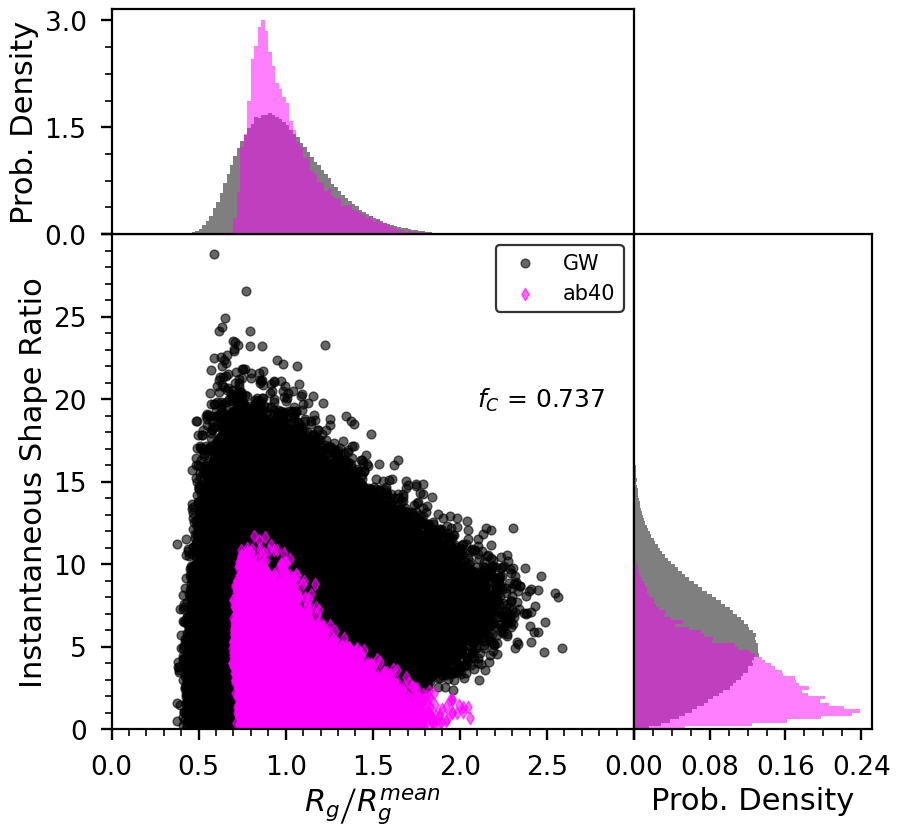

In [37]:
map_2d.plot_protein_against_GW('ab40')


In [38]:
map_2d.GW_df

,chain_length,Rg2,Rend2,Rg/Rg_mean,ratio
0,100,24.502055,250.722530,0.721402,10.232714
1,100,35.391603,222.164368,0.867015,6.277319
2,100,64.015070,588.464481,1.166051,9.192593
3,100,50.672894,251.421442,1.037443,4.961656
4,100,37.537768,420.887479,0.892916,11.212374
...,...,...,...,...,...
719995,100,66.564485,310.775147,1.189043,4.668783
719996,100,119.291205,972.647027,1.591771,8.153552
719997,100,74.587018,365.816020,1.258659,4.904554
719998,100,70.248514,331.818938,1.221504,4.723501


In [39]:
map_2d.poly_var

,Rg/Rg_mean,ratio
0,0.913208,4.171487
1,0.946811,2.812929
2,0.915198,3.160109
3,0.852798,3.056337
4,0.914420,3.516996
...,...,...
29972,1.367829,2.619682
29973,1.366376,4.038183
29974,1.446957,2.668306
29975,1.397394,1.009414


### Plot how fC varies with the number of protein/polymer snapshots

this might take a couple of minutes
if it takes too long to run, please consider a lower no_dots value (default set at 20)


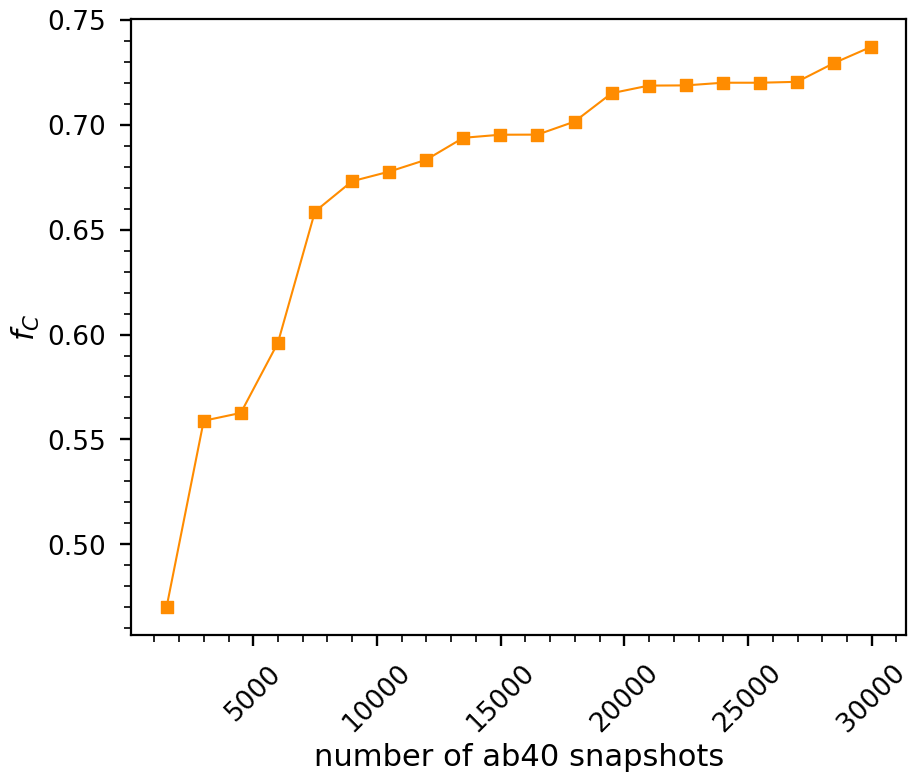

In [48]:
map_2d.vary_protein('ab40')
plt.savefig('fc_vary.png', dpi = 300)

New axis limits generated


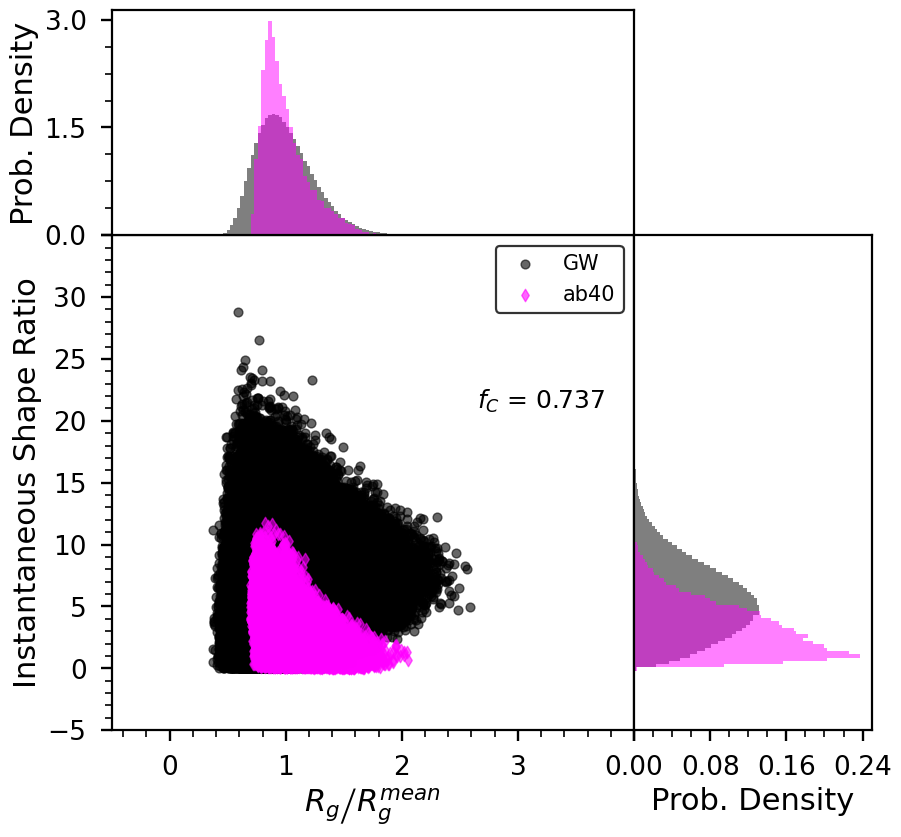

In [41]:
# adjust axis limits and replot
#input desired x-axis and y-axis limits
map_2d.change_xlim_ylim(-0.5,-5,4,35)

#generate same scatter plot but with new axis limits
map_2d.plot_protein_against_GW('ab40')

### Change Reference GW Simulation

In [50]:

# as an example, here is how one can conduct another simulation to use as reference
# chain length and number of snapshots can be decided by the user

#here is a new simulation (GW, chain length 100, 100000 snapshots) to save as a reference 
map_2d.regenerate_GW_chain(100,300000)

#output shows what the new reference GW data (pandas dataframe) looks like

New GW reference chain of length 100 has been initialized for this instance


,chain_length,Rg2,Rend2,Rg/Rg_mean,ratio
0,100,58.200895,504.248425,1.112010,8.663929
1,100,94.646844,1147.514879,1.418067,12.124175
2,100,28.756699,164.700066,0.781652,5.727363
3,100,59.852512,536.231274,1.127678,8.959211
4,100,63.802638,333.171707,1.164295,5.221911
...,...,...,...,...,...
299995,100,37.612873,293.971326,0.893947,7.815710
299996,100,30.689129,158.066975,0.807488,5.150585
299997,100,55.834761,329.206756,1.089171,5.896090
299998,100,31.676279,155.996934,0.820372,4.924724


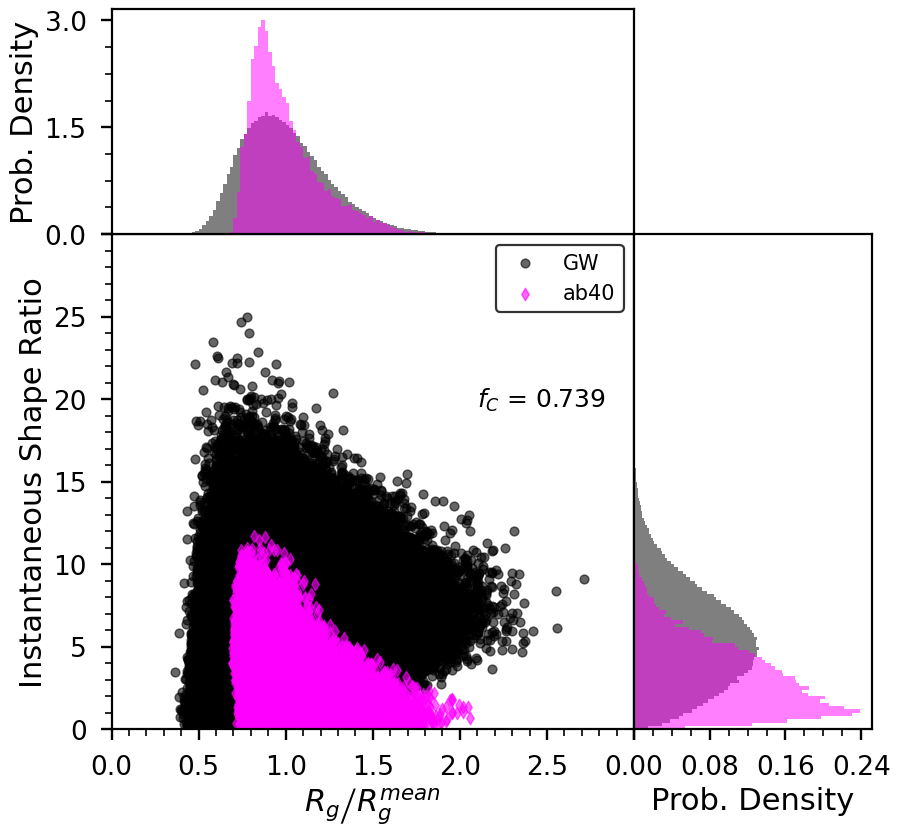

In [51]:
#replot example protein with new reference simulation
#black dots are have slightly different coordinates since its a new simulation
#still using new axis limits

map_2d.plot_protein_against_GW('ab40')
plt.savefig('ab40_protein_against_GW_2.png', dpi = 300)

In [44]:
#save this current GW reference simulation to a csv file
map_2d.save_GW_chain_to_csv()

#the saved file has default filename GW_chain_simulation.csv and saved in 'current' directory


### Re-load Default GW Chain

New axis limits generated


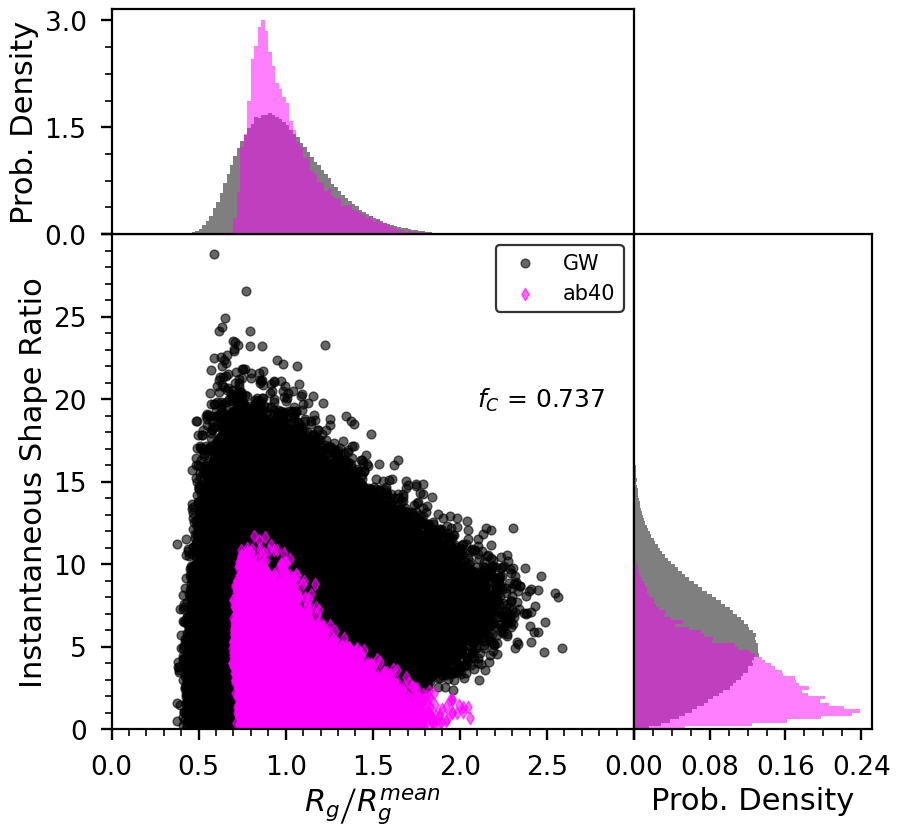

In [47]:
# this re-loads the default (provided) GW reference simulation back into the variable/instance
map_2d.retrieve_default_GW_chain()
#reset x-axis and y-axis limits to default values
map_2d.change_xlim_ylim(0,0,3,30)


#reproduces original plot
map_2d.plot_protein_against_GW('ab40')
#
plt.savefig('ab40_protein_against_GW.png', dpi = 300)